# Geospatial Analysis II (Raster Operations)

## What is a Raster?

![raster24](images/raster24.png)

Any **pixel-based picture data (JPG, png, TIFF)** can be called a raster. Let's look at a representational diagram for a raster

![raster1](images/raster1.png)

Just by knowing the coordinates of top left corner, cell dimensions (Cx and Cy) and number of rows and columns, we can calculate the location (coordinates) of any cell. 

For a geographical raster the coordinates will be either in geographical or projected coordinates. An example of such a file type is GeoTIFF (TIFF with geographical coordinates). 

**Resolution of raster** is defined as the area that a single raster cell covers. When we say resolution is 1kmX1km it means each cell has width and height as 1km. 

![raster25](images/raster25.png)

We will be dealing with GeoTIFF thorugh out this chapter.

## Why do we use rasters?

We generally use rasters to map continuous data (for example population, weather, air quality etc). For example suppose we have air quality monitors that capture various air quality indicators such as the amount of PM2.5, CO, or other particulate matters. Normally a City/Corporation would install them in some key areas such as near factories, or heavy traffic zones etc. 

![raster2](images/raster2.png)

Now what if you want to know the air quality for an area as shown in the diagram. 

![raster3](images/raster3.png)

The vectors (the air quality monitor locations) might not be much helpful here. But what if we can generate a raster (surface from this air quality monitor readings)

![raster4](images/raster4.png)

Now we can see that our plot is in an area of high values. We can take the average value for the cells that intersects with the plot (.82).

But how do we generate this raster?

We use a technique called **spatial interpolation**, which is based on the property of spatial autocorrelation. We will cover spatial interpolation and spatial autocorrelation in the next chapter. 

Once we have such a surface with values ,we can find out values for any vector (points, lines or polygons) that falls with in the area covered by the raster. 

Next we will look some common raster operations


## Raster Operations

First lets load a raster dataset to QGIS. For this example we will use a SVI Raster. We have already seen SVI for the Ohio counties as well as Ohio Census Tracts.

1. Download the dataset from  https://cwru.box.com/s/k98x22ksbsfa4vhndmui2f71xz6ho5s4 (unzip and there will be a tiff file). Use the tiff file svi_2018_tract_overall_wgs84.tiff

2. Load the raster dataset to QGIS

![raster5](images/raster5.png)

You will see an image of US. The lowest value for a cell is 0 (low vulnerability) and the highest value is 1 (High Vulnerability)

3. Let's make this map more appealing by changing symbology

Go to Properties and select Symbology. Change Render type as Singleband Psuedocolor. Use RdYlGn color ramp and invert it. The mode can be continuous (you can play around with it)

![raster6](images/raster6.png)

Click on apply and you will have a new raster image with green shades indicating areas with low vulnerability and red shades indicating areas with high vulnerability

![raster7](images/raster7.png)

Let's try that in Python

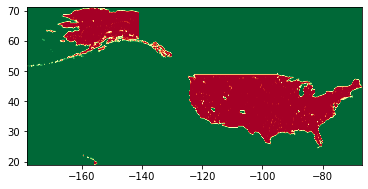

In [1]:
import rasterio
from rasterio.plot import show
src = rasterio.open("../sharedData/usgrid-us-social-vulnerability-index-tract-2018-wgs84-geotiff/usgrid-us-social-vulnerability-index-tract-2018-wgs84-geotiff/svi_2018_tract_overall_wgs84.tif")
show(src.read(1), transform=src.transform, cmap='RdYlGn_r');

Now what if I want to extract out the cells that fall within the state of Ohio

### Clipping

A raster dataset can also be clipped similar to a vector dataset.  The input raster is overlaid by a vector polygon clip layer. The raster clip process results in a single raster that is identical to the input raster but shares the extent of the polygon clip layer. 

Let's try an example. We will clip the SVI raster using Ohio boundaries (Ohio_COUNTY_SVI)

1. Load the raster and vector datasets (svi_2018_tract_overall_wgs84.tiff,Ohio_COUNTY_SVI) into QGIS

![raster8](images/raster8.png)

2. Select Clip Raster by Mask Layer from Raster Extraction

![raster9](images/raster9.png)

3. Select the input layer as the raster and mask layer as Ohio_COUNTY_SVI

![raster10](images/raster10.png)

4. Once the run is complete we can see the clipped raster as a new layer

![raster11](images/raster11.png)

5. You can change the symbology for the new raster, change its transparency and overlay it on top of a reference map for better exploration.

![raster12](images/raster12.png)

Now what if we want to get some statistics about the vector layer we are interested about

**Note**: When you are doing clipping make sure that the raster and the mask (vector) are in the same projection. 

Now lets try that in Python

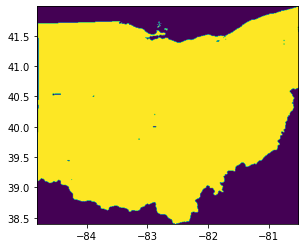

In [2]:
import rasterio
import rasterio.mask
import geopandas as gpd
from rasterio.plot import show
shapes = gpd.read_file('../sharedData/Ohio_COUNTY_SVI/SVI2018_OHIO_county.shp').geometry.values
with rasterio.open("../sharedData/usgrid-us-social-vulnerability-index-tract-2018-wgs84-geotiff/usgrid-us-social-vulnerability-index-tract-2018-wgs84-geotiff/svi_2018_tract_overall_wgs84.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    show(out_image, transform=out_transform);

### Zonal Statistics

Suppose you want to find out the average SVI value for some selected areas in Cuyahoga County. How will you do that? Let's try an example

1. Download the selected area polygons from https://cwru.box.com/s/bzr5o793sk8vedbxqc00yiyfk92ayb48

2. Load the Ohio raster that we just clipped and the area polygons

![raster13](images/raster13.png)

3. Click on toolbox

![raster14](images/raster14.png)

4. Now from Raster Analysis select Zonal Statistics

![raster15](images/raster15.png)

5. Select input layer as the polygons and raster layer as the clipped raster. Select Count Sum Mean Median Minimum Maximum for statistics to calculate

![raster16](images/raster16.png)

6. A new polygon file with the required stats will be created

![raster17](images/raster17.png)

Now let's try that in Python

In [3]:
import rasterstats
from rasterstats import zonal_stats
import pandas as pd
polydata = gpd.read_file(r'../sharedData/Areas for Covid Analysis/Areas for Covid Analysis_2d.shp')
zstats = zonal_stats(polydata, "../sharedData/usgrid-us-social-vulnerability-index-tract-2018-wgs84-geotiff/usgrid-us-social-vulnerability-index-tract-2018-wgs84-geotiff/svi_2018_tract_overall_wgs84.tif",
            stats="count min mean max median")
out = pd.concat([polydata,pd.DataFrame(zstats)],axis=1)

### Mathematical Raster Overlay

The mathematical raster overlay is the most common overlay method. The numbers within the aligned cells of the input grids can undergo any user-specified mathematical transformation.

For this example we are going to use PM2.5 data for Ohio for the years 1998 and 2019 and see the differences

1. Download the 1998 dataset from https://cwru.box.com/s/4tqti3q7rplsa3mzqwym2yeckbe0mk5l and 2019 dataset from https://cwru.box.com/s/f8xkaqrngkd5ok7ll7rrj2bevmh7wom5

2. Load both datasets to QGIS

3. Just for better exploration you can use symbology and provide a color ramp

![raster18](images/raster18.png)

Form the raster maps it can be gleaned that while in 1998 the PM2.5 concentration was higher in south western region of Ohio, it has shifted more towards the North-West region by 2019

4. Now can we find out where has been an increase/decrease in Pm2.5 concentration? We can do this by subtracting the 1998 from the 2019 raster.

5. Click on Raster and select Raster Calculator. 

![raster19](images/raster19.png)

6. Now first click on the ohio_2019_pm2.5 from the raster band, then click on subtract operator and then click on ohio_1998_pm2.5 raster. Select output layer as any location on your computer and provide a filename. 

![raster20](images/raster20.png)

7. Click ok and you will have a new layer with the value differences between the two layers. A first glance on the max and min value indicates that the PM2.5 value has lessened over the years (the maximum reduction being 15.4 and minimum being 2.9). Now we can use the symbology and the green to red color ramp to show areas that have the maximum reduction (which is great) and areas having minimum reduction. 

![raster21](images/raster21.png)

Now lets try that in Python

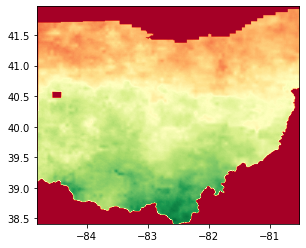

In [4]:
import rasterio
from rasterio.plot import show
with rasterio.open("../sharedData/ohio_1998_pm2.5.tif") as src1:
    with rasterio.open("../sharedData/ohio_2019_pm2.5.tif") as src2:
        show(src2.read(1)-src1.read(1), transform=src1.transform, cmap='RdYlGn_r');

### Global Raster Statistics

We can also calculate statistics for the entire raster data. Lets use the Ohio ohio_1998_pm2.5 and ohio_2019_pm2.5 raster dataset for this example

1. Select Raster Layer Statistics from the tool box

![raster22](images/raster22.png)

2. Select ohio_1998_pm2.5 and click Run and do the same for ohio_2019_pm2.5

3. A new HTML file will be created with the statistics which you can open from the Result Viewer

![raster23](images/raster23.png)

4. By checking both the results you can see that the mean value has almost halved between 1998 and 2019 (Pm2.5 decreased).

We will look at surface analysis methods for raster in the next chapter (Advanced Analysis)

There is also a major area of raster analysis that we have omitted here called Terrain Mapping which is a key area of analysis for Geology, Hydrology. Raster analysis skills are key while using remotely sensed data.